In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv


# Import Python Libraries #

In [2]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# To suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To tune model, get different metric scores, and split data
from sklearn import metrics
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To do hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To help with model building
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To supress warnings
import warnings
warnings.filterwarnings("ignore")

## Load dataset ##

In [3]:
credit_df = pd.read_csv("/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv")

## Data Overview ##

In [4]:
credit_df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.000,PERSONAL,D,35000,16.020,1,0.590,Y,3
1,21,9600,OWN,5.000,EDUCATION,B,1000,11.140,0,0.100,N,2
2,25,9600,MORTGAGE,1.000,MEDICAL,C,5500,12.870,1,0.570,N,3
3,23,65500,RENT,4.000,MEDICAL,C,35000,15.230,1,0.530,N,2
4,24,54400,RENT,8.000,MEDICAL,C,35000,14.270,1,0.550,Y,4


In [5]:
credit_df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32581.000,27.735,6.348,20.000,23.000,26.000,30.000,144.000
person_income,32581.000,66074.848,61983.119,4000.000,38500.000,55000.000,79200.000,6000000.000
person_emp_length,31686.000,4.790,4.143,0.000,2.000,4.000,7.000,123.000
loan_amnt,32581.000,9589.371,6322.087,500.000,5000.000,8000.000,12200.000,35000.000
loan_int_rate,29465.000,11.012,3.240,5.420,7.900,10.990,13.470,23.220
loan_status,32581.000,0.218,0.413,0.000,0.000,0.000,0.000,1.000
loan_percent_income,32581.000,0.170,0.107,0.000,0.090,0.150,0.230,0.830
cb_person_cred_hist_length,32581.000,5.804,4.055,2.000,3.000,4.000,8.000,30.000


In [6]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [7]:
# let's check for missing values in the data
credit_df.isnull().sum() ##  Complete the code to check missing entries in the data

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

There are missing values in int_rate and emp_length columns

In [8]:
# statistical summary of the dataset with categorical data
credit_df.describe(include=["object"]).T

,count,unique,top,freq
person_home_ownership,32581,4,RENT,16446
loan_intent,32581,6,EDUCATION,6453
loan_grade,32581,7,A,10777
cb_person_default_on_file,32581,2,N,26836


In [9]:
for i in credit_df.describe(include=["object"]).columns:
    print("Unique values in", i, "are :")
    print(credit_df[i].value_counts())
    print("*" * 50)

Unique values in person_home_ownership are :
person_home_ownership
RENT        16446
MORTGAGE    13444
OWN          2584
OTHER         107
Name: count, dtype: int64
**************************************************
Unique values in loan_intent are :
loan_intent
EDUCATION            6453
MEDICAL              6071
VENTURE              5719
PERSONAL             5521
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: count, dtype: int64
**************************************************
Unique values in loan_grade are :
loan_grade
A    10777
B    10451
C     6458
D     3626
E      964
F      241
G       64
Name: count, dtype: int64
**************************************************
Unique values in cb_person_default_on_file are :
cb_person_default_on_file
N    26836
Y     5745
Name: count, dtype: int64
**************************************************


# Data Visualization # 

## Python Functions ##

In [10]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.set_style("whitegrid")
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.set_style("whitegrid")
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [11]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=11)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [12]:
# function to plot stacked bar chart

def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.xticks(rotation = 60)
    plt.show()

In [13]:
### Function to plot distributions

def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.set_style("whitegrid")
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.set_style("whitegrid")
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.set_style("whitegrid")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.set_style("whitegrid")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

## Univariate Analysis ##

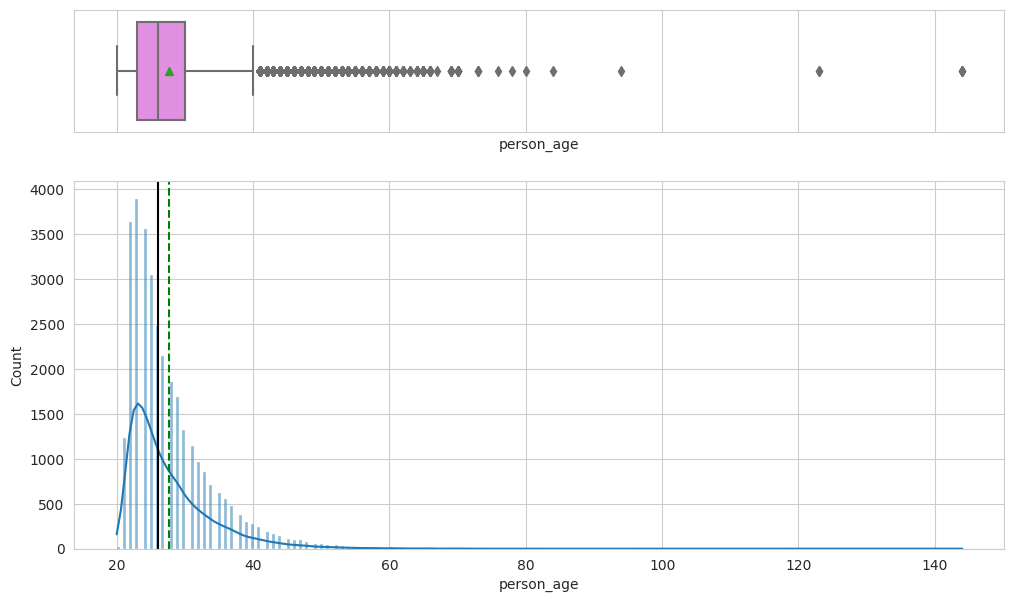

In [14]:
sns.set_style("whitegrid")
histogram_boxplot(credit_df, "person_age", kde=True)

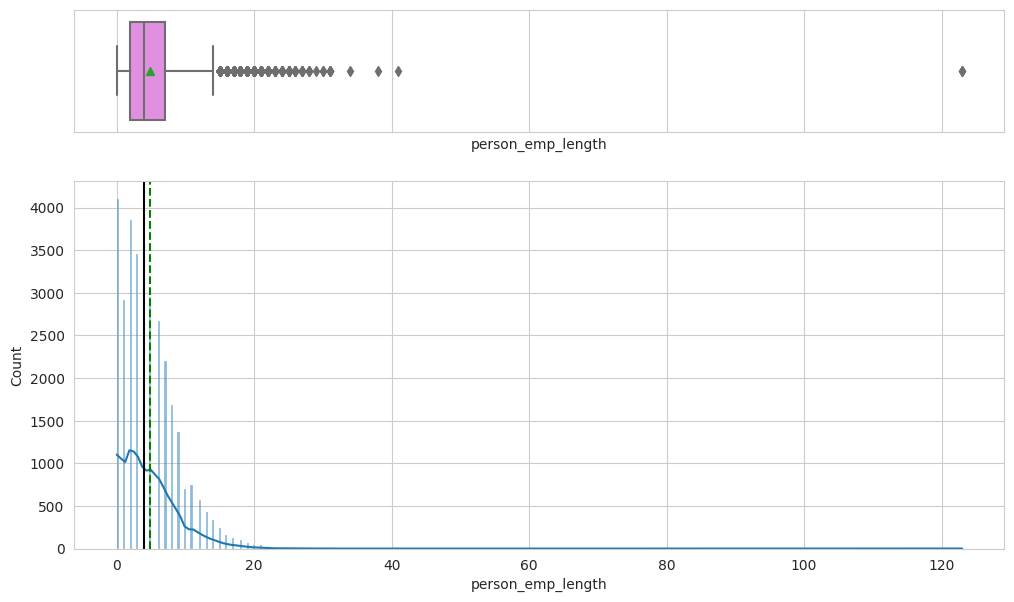

In [15]:
sns.set_style("whitegrid")
histogram_boxplot(credit_df, "person_emp_length", kde=True)

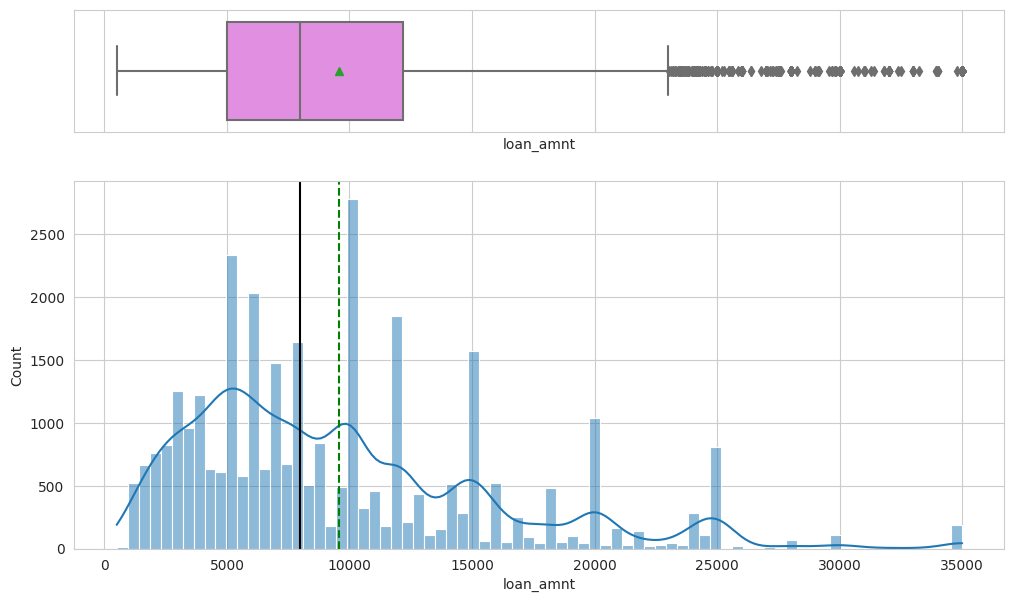

In [16]:
sns.set_style("whitegrid")
histogram_boxplot(credit_df, "loan_amnt", kde=True)

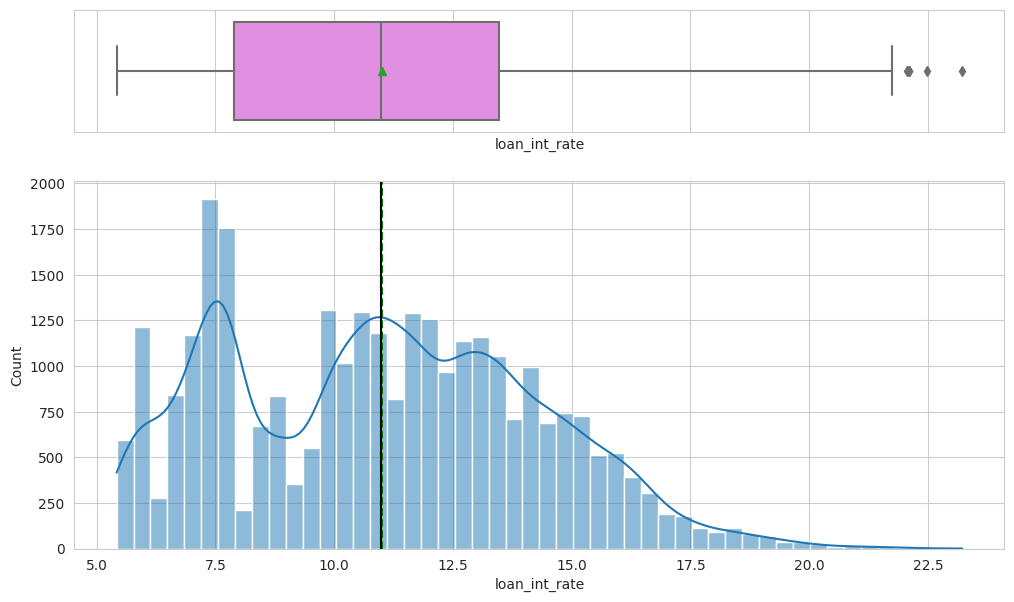

In [17]:
sns.set_style("whitegrid")
histogram_boxplot(credit_df, "loan_int_rate", kde=True)

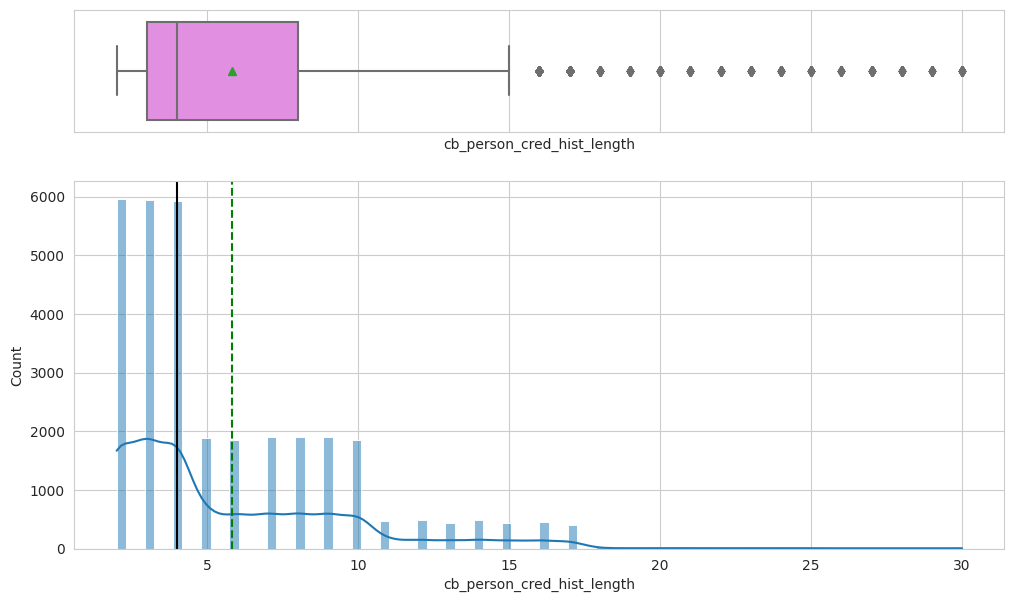

In [18]:
sns.set_style("whitegrid")
histogram_boxplot(credit_df, "cb_person_cred_hist_length", kde=True)

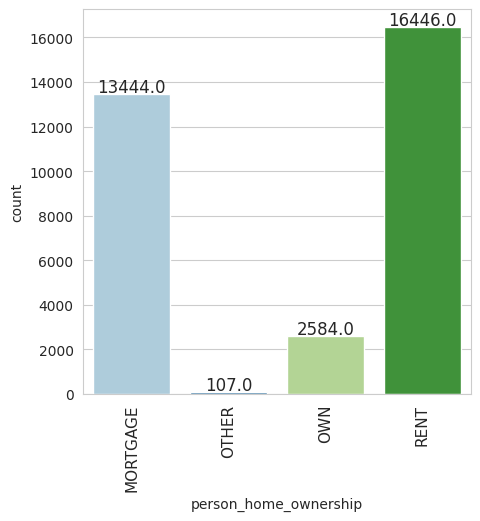

In [19]:
labeled_barplot(credit_df, "person_home_ownership")

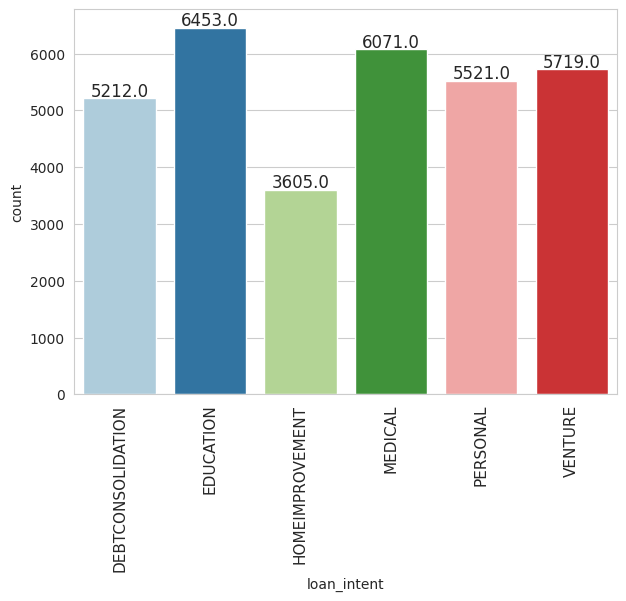

In [20]:
labeled_barplot(credit_df, "loan_intent")

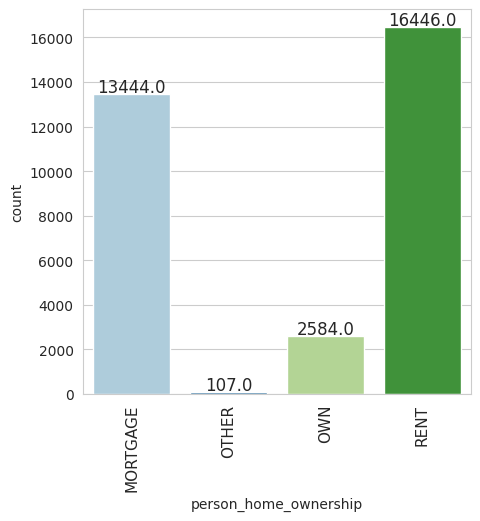

In [21]:
labeled_barplot(credit_df, "person_home_ownership")

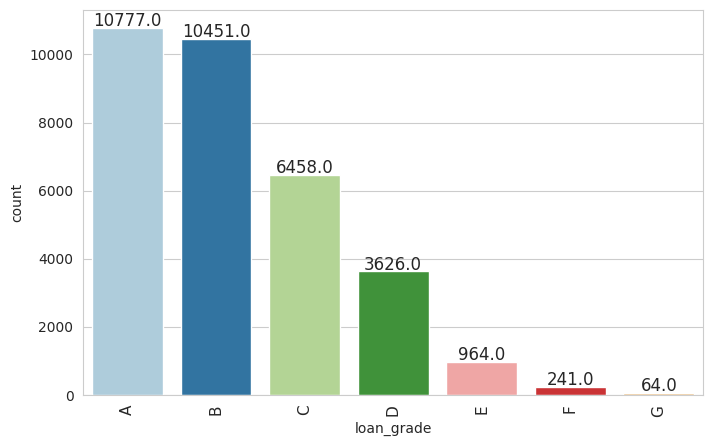

In [22]:
labeled_barplot(credit_df, "loan_grade")

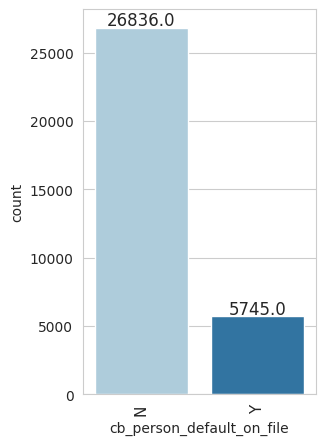

In [23]:
labeled_barplot(credit_df, "cb_person_default_on_file")

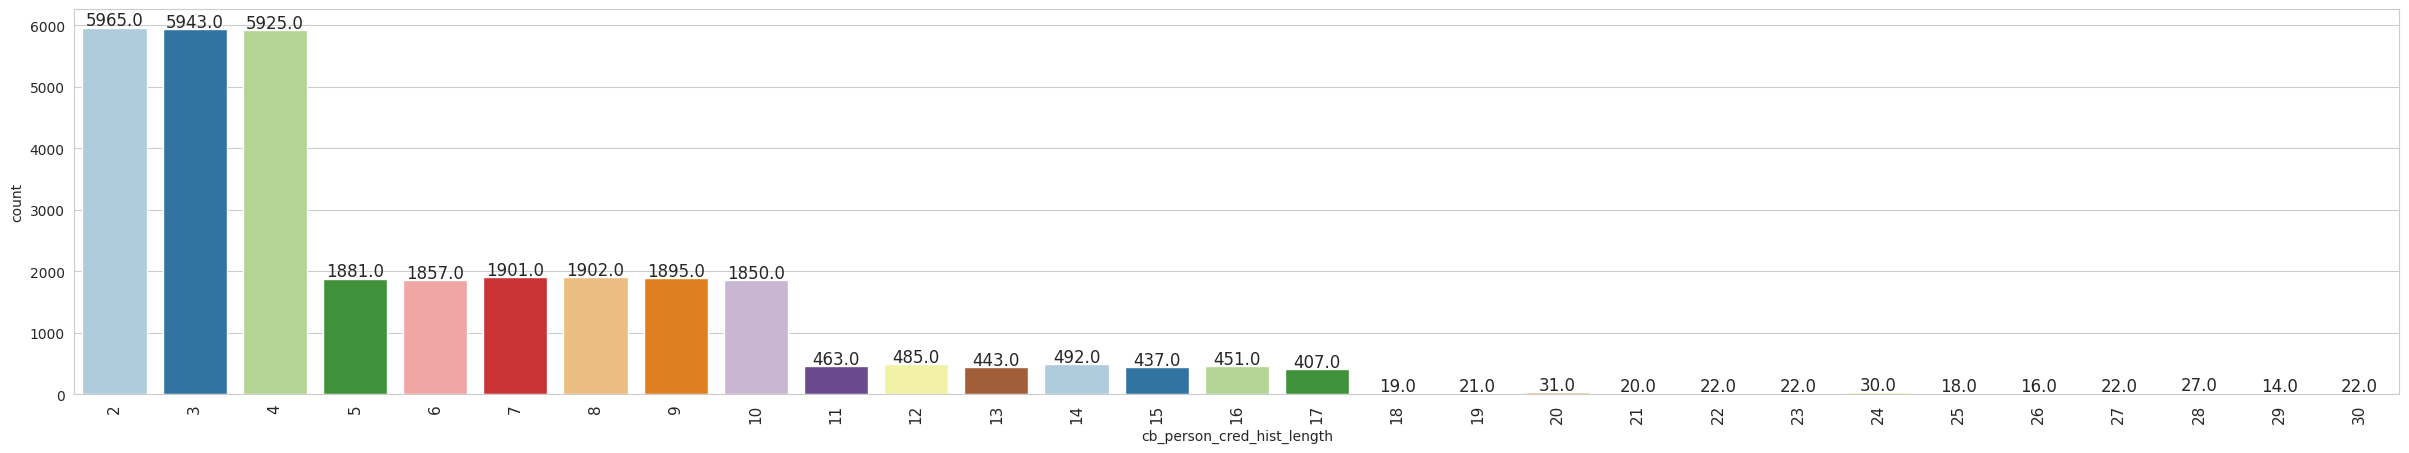

In [24]:
labeled_barplot(credit_df, "cb_person_cred_hist_length")

## Bivariate Analysis ##

## Data Prep ##

In [25]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [26]:
print(credit_df.person_home_ownership .value_counts())
print(credit_df.loan_intent.value_counts())
print(credit_df.loan_grade.value_counts())
print(credit_df.cb_person_default_on_file.value_counts())

person_home_ownership
RENT        16446
MORTGAGE    13444
OWN          2584
OTHER         107
Name: count, dtype: int64
loan_intent
EDUCATION            6453
MEDICAL              6071
VENTURE              5719
PERSONAL             5521
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: count, dtype: int64
loan_grade
A    10777
B    10451
C     6458
D     3626
E      964
F      241
G       64
Name: count, dtype: int64
cb_person_default_on_file
N    26836
Y     5745
Name: count, dtype: int64


In [27]:
credit_df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

In [28]:
numcols = ['person_age', 'person_income', 
       'person_emp_length',   'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
        'cb_person_cred_hist_length']

In [29]:
data = credit_df.copy()

In [30]:
data2 = credit_df.copy()

In [31]:
replaceStruct = {
                "cb_person_default_on_file":     {"N": 0, "Y": 1 },
                "loan_grade": {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7},
                "loan_intent": {"EDUCATION": 1, "MEDICAL": 2, "VENTURE": 3, "PERSONAL": 4, "DEBTCONSOLIDATION": 5, "HOMEIMPROVEMENT": 6},
                "person_home_ownership": {"RENT": 1, "MORTGAGE": 2, "OWN": 3, "OTHER":4},

                    }

In [32]:
oneHotCols=["cb_person_default_on_file","loan_grade","loan_intent","person_home_ownership"]

In [33]:
data=data.replace(replaceStruct)
data=pd.get_dummies(data, columns=oneHotCols, drop_first=True)
data.head(10)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,cb_person_default_on_file_1,loan_grade_2,loan_grade_3,loan_grade_4,loan_grade_5,loan_grade_6,loan_grade_7,loan_intent_2,loan_intent_3,loan_intent_4,loan_intent_5,loan_intent_6,person_home_ownership_2,person_home_ownership_3,person_home_ownership_4
0,22,59000,123.000,35000,16.020,1,0.590,3,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False
1,21,9600,5.000,1000,11.140,0,0.100,2,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False
2,25,9600,1.000,5500,12.870,1,0.570,3,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False
3,23,65500,4.000,35000,15.230,1,0.530,2,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False
4,24,54400,8.000,35000,14.270,1,0.550,4,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False
5,21,9900,2.000,2500,7.140,1,0.250,2,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
6,26,77100,8.000,35000,12.420,1,0.450,3,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
7,24,78956,5.000,35000,11.110,1,0.440,4,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False
8,24,83000,8.000,35000,8.900,1,0.420,2,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
9,21,10000,6.000,1600,14.740,1,0.160,3,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False


## Bivariate Visualization ##

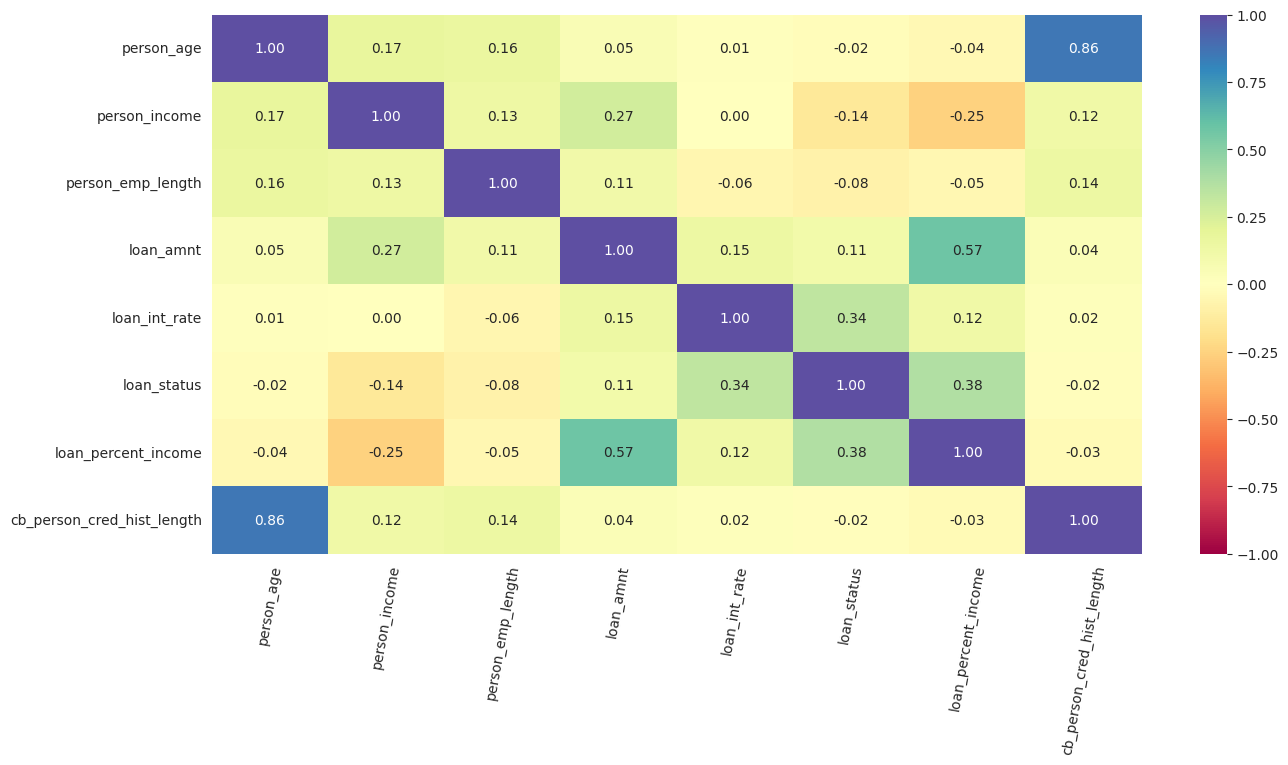

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(credit_df[numcols].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.xticks(rotation = 80)
plt.show()

loan_intent  DEBTCONSOLIDATION  EDUCATION  HOMEIMPROVEMENT  MEDICAL  PERSONAL  \
loan_status                                                                     
All                       5212       6453             3605     6071      5521   
0                         3722       5342             2664     4450      4423   
1                         1490       1111              941     1621      1098   

loan_intent  VENTURE    All  
loan_status                  
All             5719  32581  
0               4872  25473  
1                847   7108  
------------------------------------------------------------------------------------------------------------------------


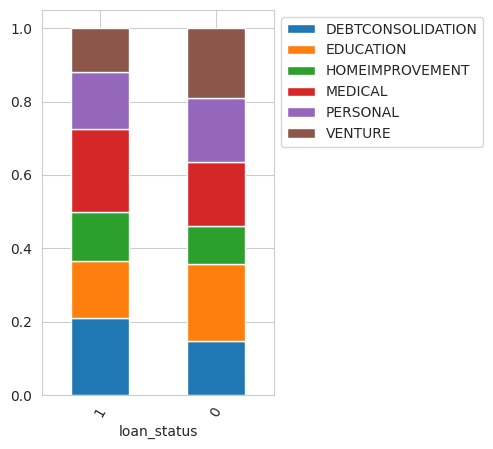

In [35]:
stacked_barplot(credit_df,"loan_status", "loan_intent")

loan_grade       A      B     C     D    E    F   G    All
loan_status                                               
All          10777  10451  6458  3626  964  241  64  32581
1             1073   1701  1339  2141  621  170  63   7108
0             9704   8750  5119  1485  343   71   1  25473
------------------------------------------------------------------------------------------------------------------------


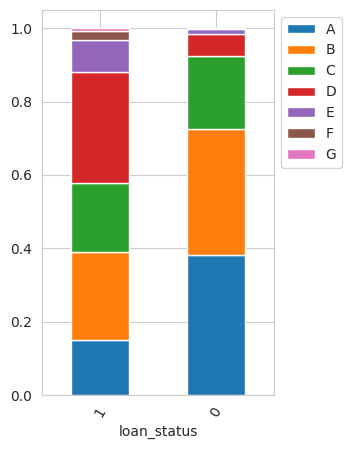

In [36]:
stacked_barplot(credit_df,"loan_status", "loan_grade")

person_home_ownership  MORTGAGE  OTHER   OWN   RENT    All
loan_status                                               
All                       13444    107  2584  16446  32581
0                         11754     74  2391  11254  25473
1                          1690     33   193   5192   7108
------------------------------------------------------------------------------------------------------------------------


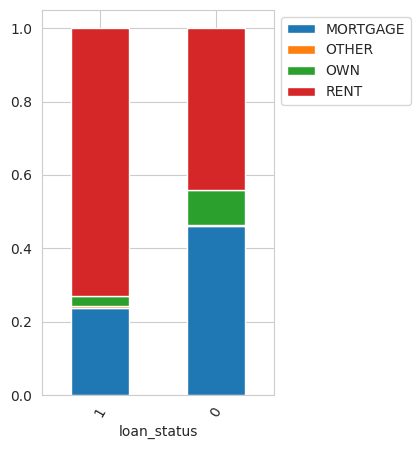

In [37]:
stacked_barplot(credit_df,"loan_status", "person_home_ownership")

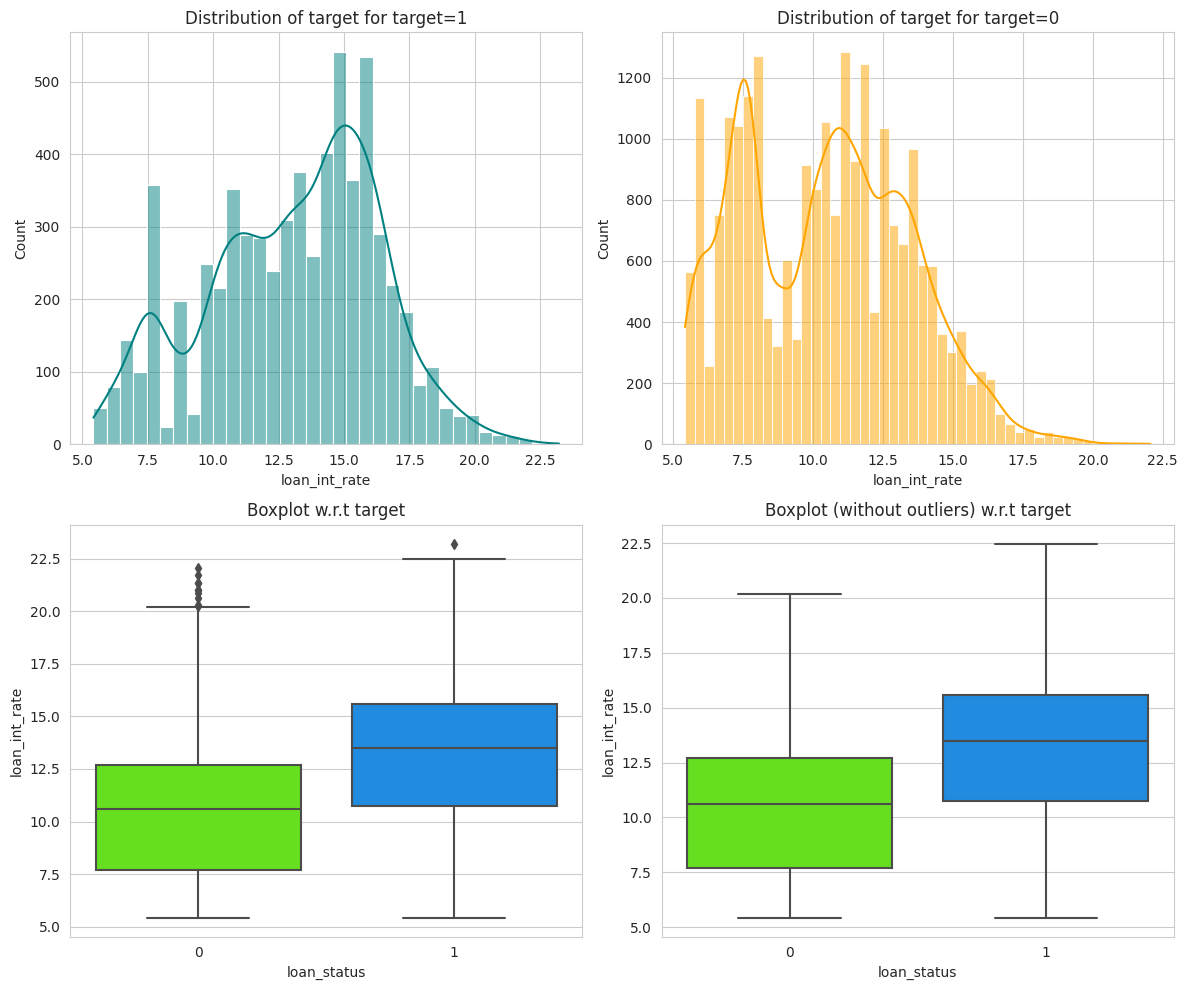

In [38]:
distribution_plot_wrt_target(credit_df, "loan_int_rate", "loan_status")

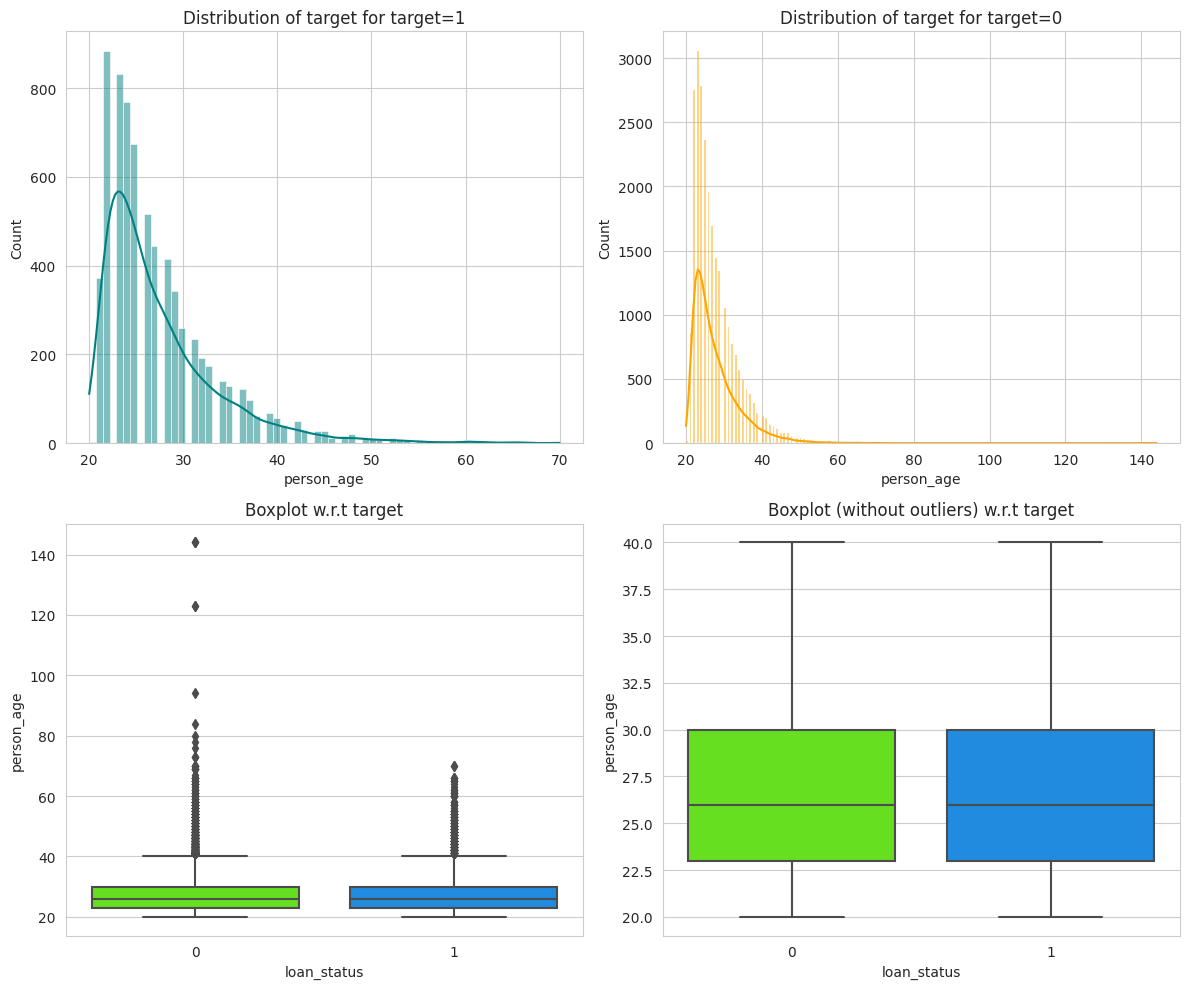

In [39]:
distribution_plot_wrt_target(credit_df, "person_age", "loan_status")

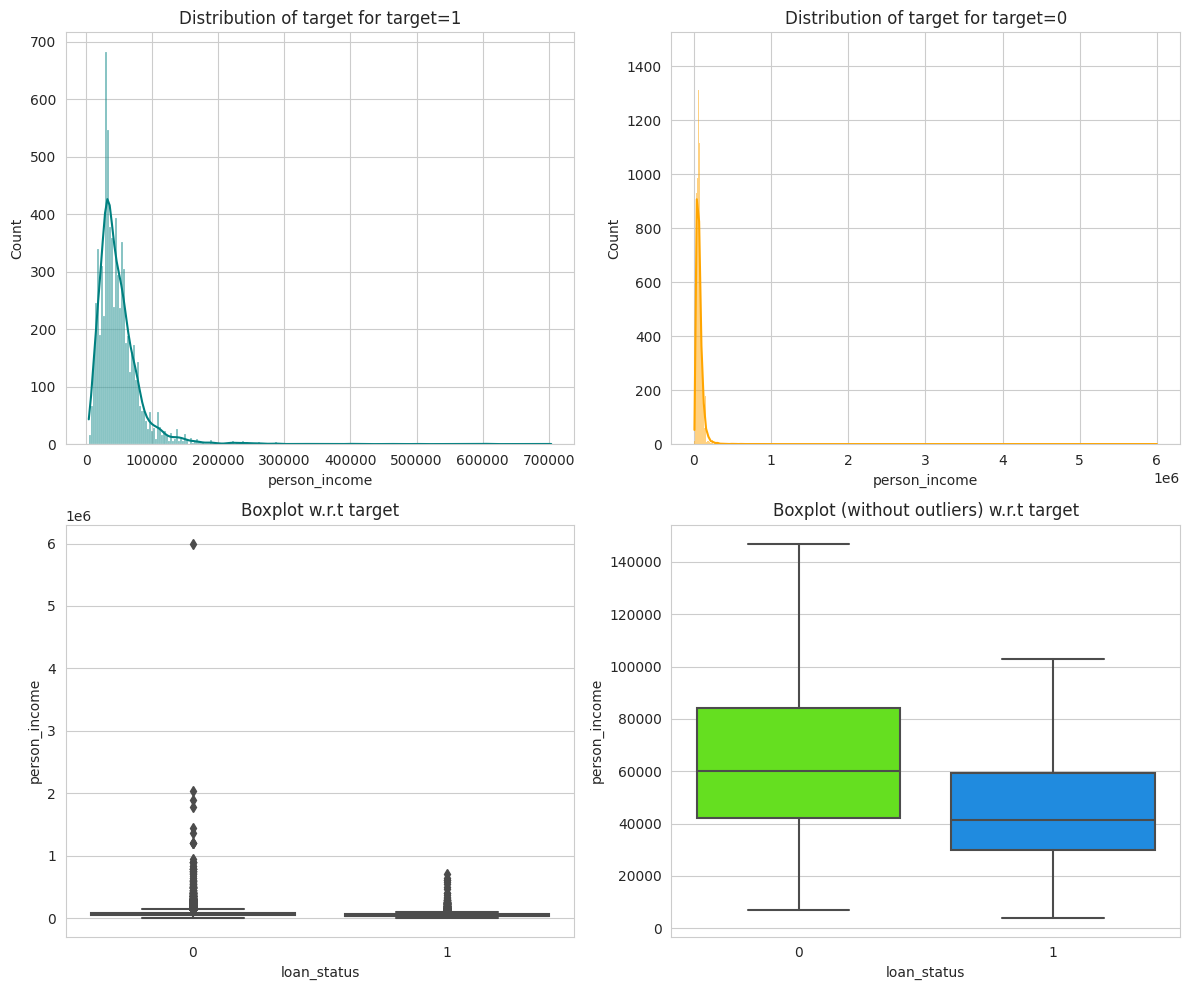

In [40]:
distribution_plot_wrt_target(credit_df, "person_income", "loan_status")

# Model Building #

## Training - Test - Validation Split ##

In [41]:
data2 = data2.drop(['person_emp_length', 'loan_int_rate'], axis=1)
data2.head()

,person_age,person_income,person_home_ownership,loan_intent,loan_grade,loan_amnt,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,PERSONAL,D,35000,1,0.590,Y,3
1,21,9600,OWN,EDUCATION,B,1000,0,0.100,N,2
2,25,9600,MORTGAGE,MEDICAL,C,5500,1,0.570,N,3
3,23,65500,RENT,MEDICAL,C,35000,1,0.530,N,2
4,24,54400,RENT,MEDICAL,C,35000,1,0.550,Y,4


In [42]:
X = data2.drop(["loan_status"], axis=1)
y = data2["loan_status"]

In [43]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=.20, random_state=1,stratify=y) ## Complete the code to split the data into train test in the ratio 80:20

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=.25, random_state=1,stratify=y_temp) ## Complete the code to split the data into train test in the ratio 75:25

print(X_train.shape, X_val.shape, X_test.shape)

(26064, 9) (1630, 9) (4887, 9)


In [44]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_val = pd.get_dummies(X_val, drop_first=True)  ## Complete the code to impute missing values in X_val
X_test = pd.get_dummies(X_test, drop_first=True)  ## Complete the code to impute missing values in X_val
print(X_train.shape, X_val.shape, X_test.shape)

(26064, 20) (1630, 20) (4887, 20)


In [45]:
X_train.head()

,person_age,person_income,loan_amnt,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
24004,28,68804,22000,0.320,6,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
18875,30,39000,1500,0.040,9,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
11855,25,76800,6500,0.080,4,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
26531,29,105000,20000,0.190,8,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
15735,24,160000,20000,0.130,2,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True


In [46]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [47]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [48]:
y_train.value_counts()

loan_status
0    20378
1     5686
Name: count, dtype: int64

## Model with Original Data ##

In [49]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("AdaBoost", AdaBoostClassifier(random_state=1)))
models.append(("GradientBoosting", GradientBoostingClassifier(random_state=1)))
models.append(("XGBoost", XGBClassifier(random_state=1, eval_metric="logloss")))


print("\n" "Training Performance:" "\n")
for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_train, model.predict(X_train))
    print("{}: {}".format(name, scores))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_val, y_val)
    scores_val = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores_val))


Training Performance:

Bagging: 0.9563841013014421
Random forest: 0.9992965177629265
AdaBoost: 0.6463243053112909
GradientBoosting: 0.6904678156876539
XGBoost: 0.7824481181850158

Validation Performance:

Bagging: 0.952247191011236
Random forest: 1.0
AdaBoost: 0.6460674157303371
GradientBoosting: 0.7415730337078652
XGBoost: 0.9943820224719101


## Model with OverSampled Data  ##

In [50]:
print("Before Oversampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before Oversampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

sm = SMOTE(
    sampling_strategy=1, k_neighbors=5, random_state=1
)  # Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After Oversampling, counts of label 'Yes': {}".format(sum(y_train_over == 1)))
print("After Oversampling, counts of label 'No': {} \n".format(sum(y_train_over == 0)))


print("After Oversampling, the shape of train_X: {}".format(X_train_over.shape))
print("After Oversampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before Oversampling, counts of label 'Yes': 5686
Before Oversampling, counts of label 'No': 20378 

After Oversampling, counts of label 'Yes': 20378
After Oversampling, counts of label 'No': 20378 

After Oversampling, the shape of train_X: (40756, 20)
After Oversampling, the shape of train_y: (40756,) 



In [51]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("AdaBoost", AdaBoostClassifier(random_state=1)))
models.append(("GradientBoosting", GradientBoostingClassifier(random_state=1)))
models.append(("XGBoost", XGBClassifier(random_state=1, eval_metric="logloss")))


print("\n" "Training Performance:" "\n")
for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_train_over, model.predict(X_train_over))  ## Complete the code to build models on oversampled data
    print("{}: {}".format(name, scores))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Training Performance:

Bagging: 0.989841986455982
Random forest: 0.9998037098832073
AdaBoost: 0.8822259299244283
GradientBoosting: 0.8921876533516537
XGBoost: 0.9326234174109334

Validation Performance:

Bagging: 0.7303370786516854
Random forest: 0.7247191011235955
AdaBoost: 0.702247191011236
GradientBoosting: 0.7471910112359551
XGBoost: 0.7415730337078652


## Model with Under Sampled Data ##

In [52]:
rus = RandomUnderSampler(random_state=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [53]:
print("Before Under Sampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before Under Sampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

print("After Under Sampling, counts of label 'Yes': {}".format(sum(y_train_un == 1)))
print("After Under Sampling, counts of label 'No': {} \n".format(sum(y_train_un == 0)))

print("After Under Sampling, the shape of train_X: {}".format(X_train_un.shape))
print("After Under Sampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before Under Sampling, counts of label 'Yes': 5686
Before Under Sampling, counts of label 'No': 20378 

After Under Sampling, counts of label 'Yes': 5686
After Under Sampling, counts of label 'No': 5686 

After Under Sampling, the shape of train_X: (11372, 20)
After Under Sampling, the shape of train_y: (11372,) 



In [54]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("AdaBoost", AdaBoostClassifier(random_state=1)))
models.append(("GradientBoosting", GradientBoostingClassifier(random_state=1)))
models.append(("XGBoost", XGBClassifier(random_state=1, eval_metric="logloss")))


print("\n" "Training Performance:" "\n")
for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_train_un, model.predict(X_train_un))  ## Complete the code to build models on undersampled data
    print("{}: {}".format(name, scores))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Training Performance:

Bagging: 0.9810059795990151
Random forest: 1.0
AdaBoost: 0.7956384101301442
GradientBoosting: 0.7864931410481886
XGBoost: 0.9032711924023918

Validation Performance:

Bagging: 0.8117977528089888
Random forest: 0.797752808988764
AdaBoost: 0.7865168539325843
GradientBoosting: 0.7808988764044944
XGBoost: 0.8258426966292135


## AdaBoost Model Training with Original Data ##

In [55]:
%%time

# defining model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": np.arange(50,110,25),
    "learning_rate": [0.01,0.1,0.05],
    "estimator": [
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1),
    ],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_jobs = -1, n_iter=50, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train) ## Complete the code to fit the model on original data

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 100, 'learning_rate': 0.1, 'estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.6925790590661146:
CPU times: user 4.14 s, sys: 250 ms, total: 4.39 s
Wall time: 1min 11s


## AdaBoost with Under Sampled Data ##

In [56]:
# Creating new pipeline with best parameters
tuned_ada2 = AdaBoostClassifier( random_state=1,
    n_estimators= 100, learning_rate= 0.1, base_estimator= DecisionTreeClassifier(max_depth=3, random_state=1)
) ## Complete the code with the best parameters obtained from tuning

tuned_ada2.fit(X_train_un, y_train_un) ## Complete the code to fit the model on undersampled data

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=0.1, n_estimators=100, random_state=1)

In [57]:
adb2_train = model_performance_classification_sklearn(tuned_ada2, X_train, y_train) ## Complete the code to check the performance on training set
adb2_train

,Accuracy,Recall,Precision,F1
0,0.905,0.783,0.782,0.782


In [58]:
# Checking model's performance on validation set
adb2_val =  model_performance_classification_sklearn(tuned_ada2, X_val, y_val) ## Complete the code to check the performance on validation set
adb2_val

,Accuracy,Recall,Precision,F1
0,0.899,0.770,0.770,0.770


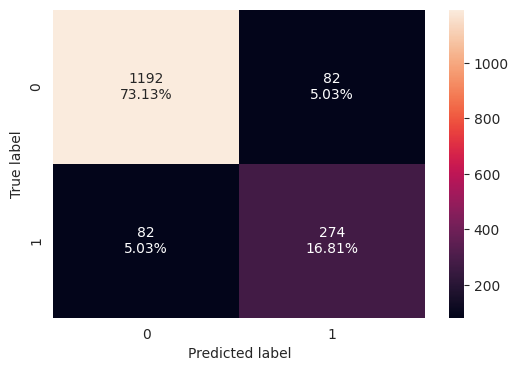

In [59]:
confusion_matrix_sklearn(tuned_ada2, X_val, y_val)

 ## AdaBoost with Over Sampled Data ##

In [60]:
# Creating new pipeline with best parameters
tuned_ada1 = AdaBoostClassifier( random_state=1,
    n_estimators= 100, learning_rate= 0.1, base_estimator= DecisionTreeClassifier(max_depth=3, random_state=1)
) ## Complete the code with the best parameters obtained from tuning

tuned_ada1.fit(X_train_over, y_train_over) ## Complete the code to fit the model on undersampled data

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=0.1, n_estimators=100, random_state=1)

In [61]:
adb1_train = model_performance_classification_sklearn(tuned_ada1, X_train, y_train) ## Complete the code to check the performance on training set
adb1_train

,Accuracy,Recall,Precision,F1
0,0.920,0.736,0.878,0.801


In [62]:
adb1_val = model_performance_classification_sklearn(tuned_ada1, X_val, y_val) ## Complete the code to check the performance on training set
adb1_val

,Accuracy,Recall,Precision,F1
0,0.921,0.728,0.890,0.801


## Gradient Boost with Under Sampled Data ##

In [63]:
%%time

#Creating pipeline
Model = GradientBoostingClassifier(random_state=1)

#Parameter grid to pass in RandomSearchCV
param_grid = {
    "init": [AdaBoostClassifier(random_state=1),DecisionTreeClassifier(random_state=1)],
    "n_estimators": np.arange(50,110,25),
    "learning_rate": [0.01,0.1,0.05],
    "subsample":[0.7,0.9],
    "max_features":[0.5,0.7,1],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1, n_jobs = -1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un, y_train_un) ## Complete the code to fit the model on under sampled data


print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 100, 'max_features': 0.7, 'learning_rate': 0.05, 'init': DecisionTreeClassifier(random_state=1)} with CV score=0.8105865495638787:
CPU times: user 2.1 s, sys: 206 ms, total: 2.31 s
Wall time: 60 s


In [64]:
# Creating new pipeline with best parameters
tuned_gbm1 = GradientBoostingClassifier(
    max_features=0.7,
    init=AdaBoostClassifier(random_state=1),
    random_state=1,
    learning_rate=0.05,
    n_estimators=100,
    subsample=0.7,
)## Complete the code with the best parameters obtained from tuning

tuned_gbm1.fit(X_train_un, y_train_un)

GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                           learning_rate=0.05, max_features=0.7, random_state=1,
                           subsample=0.7)

In [65]:
gbm1_train = model_performance_classification_sklearn(tuned_gbm1, X_train_un, y_train_un) ## Complete the code to check the performance on undersampled train set
gbm1_train

,Accuracy,Recall,Precision,F1
0,0.847,0.780,0.901,0.836


In [66]:
gbm1_val = model_performance_classification_sklearn(tuned_gbm1, X_val, y_val) ## Complete the code to check the performance on validation set
gbm1_val

,Accuracy,Recall,Precision,F1
0,0.879,0.775,0.702,0.737


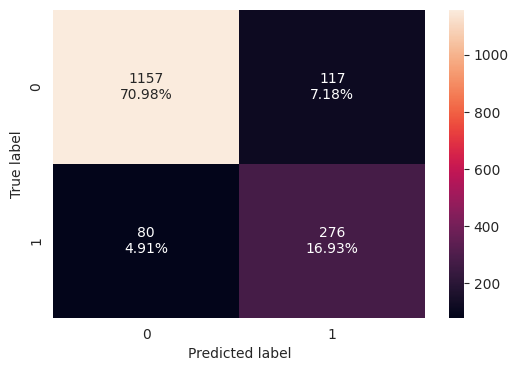

In [67]:
confusion_matrix_sklearn(tuned_gbm1, X_val, y_val)

## Tuning with XGBoost ##

In [68]:
%%time

# defining model
Model = XGBClassifier(random_state=1,eval_metric='logloss')

#Parameter grid to pass in RandomSearchCV
param_grid={'n_estimators':np.arange(50,110,25),
            'scale_pos_weight':[1,2,5],
            'learning_rate':[0.01,0.1,0.05],
            'gamma':[1,3],
            'subsample':[0.7,0.9]
           }
from sklearn import metrics

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over) ## Complete the code to fit the model on original data

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'scale_pos_weight': 5, 'n_estimators': 50, 'learning_rate': 0.01, 'gamma': 3} with CV score=1.0:
CPU times: user 2.43 s, sys: 306 ms, total: 2.74 s
Wall time: 45.7 s


In [69]:
tuned_xgb = XGBClassifier(
    random_state=1,
    eval_metric="logloss",
    subsample=0.7,
    scale_pos_weight=5,
    n_estimators=50,
    learning_rate=0.01,
    gamma=3,
)## Complete the code with the best parameters obtained from tuning

tuned_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=3, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

In [70]:
xgb_train = model_performance_classification_sklearn(tuned_xgb, X_train_un, y_train_un) ## Complete the code to check the performance on original train set
xgb_train

,Accuracy,Recall,Precision,F1
0,0.827,0.830,0.825,0.827


In [71]:
xgb_val = model_performance_classification_sklearn(tuned_xgb, X_val, y_val) ## Complete the code to check the performance on validation set
xgb_val

,Accuracy,Recall,Precision,F1
0,0.814,0.809,0.551,0.655


In [72]:
xgb_train = model_performance_classification_sklearn(tuned_xgb, X_train_over, y_train_over) ## Complete the code to check the performance on original train set
xgb_train

,Accuracy,Recall,Precision,F1
0,0.859,0.892,0.836,0.863


## Model Comparisons ##

In [73]:
# original data performance comparison

models_origin_comp_df = pd.concat(
    [
        adb1_train.T,
        adb1_val.T,
        gbm1_train.T,
        gbm1_val.T,
    ],
    axis=1,
)
models_origin_comp_df.columns = [
    "AdaBoost trained with Original data",
    "AdaBoost validated with Original data",
    "Gradient boosting trained with Original data",
    "Gradient boosting validated with Original data",

]
print("original data performance comparison:")
models_origin_comp_df

original data performance comparison:


,AdaBoost trained with Original data,AdaBoost validated with Original data,Gradient boosting trained with Original data,Gradient boosting validated with Original data
Accuracy,0.920,0.921,0.847,0.879
Recall,0.736,0.728,0.780,0.775
Precision,0.878,0.890,0.901,0.702
F1,0.801,0.801,0.836,0.737


## Feature Importances ##

7
258396561## feature_names = X_train.columns
importanc2es =  tuned_xgb.feature_importances_ ## Complete the code to check the feature importance of the best model
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

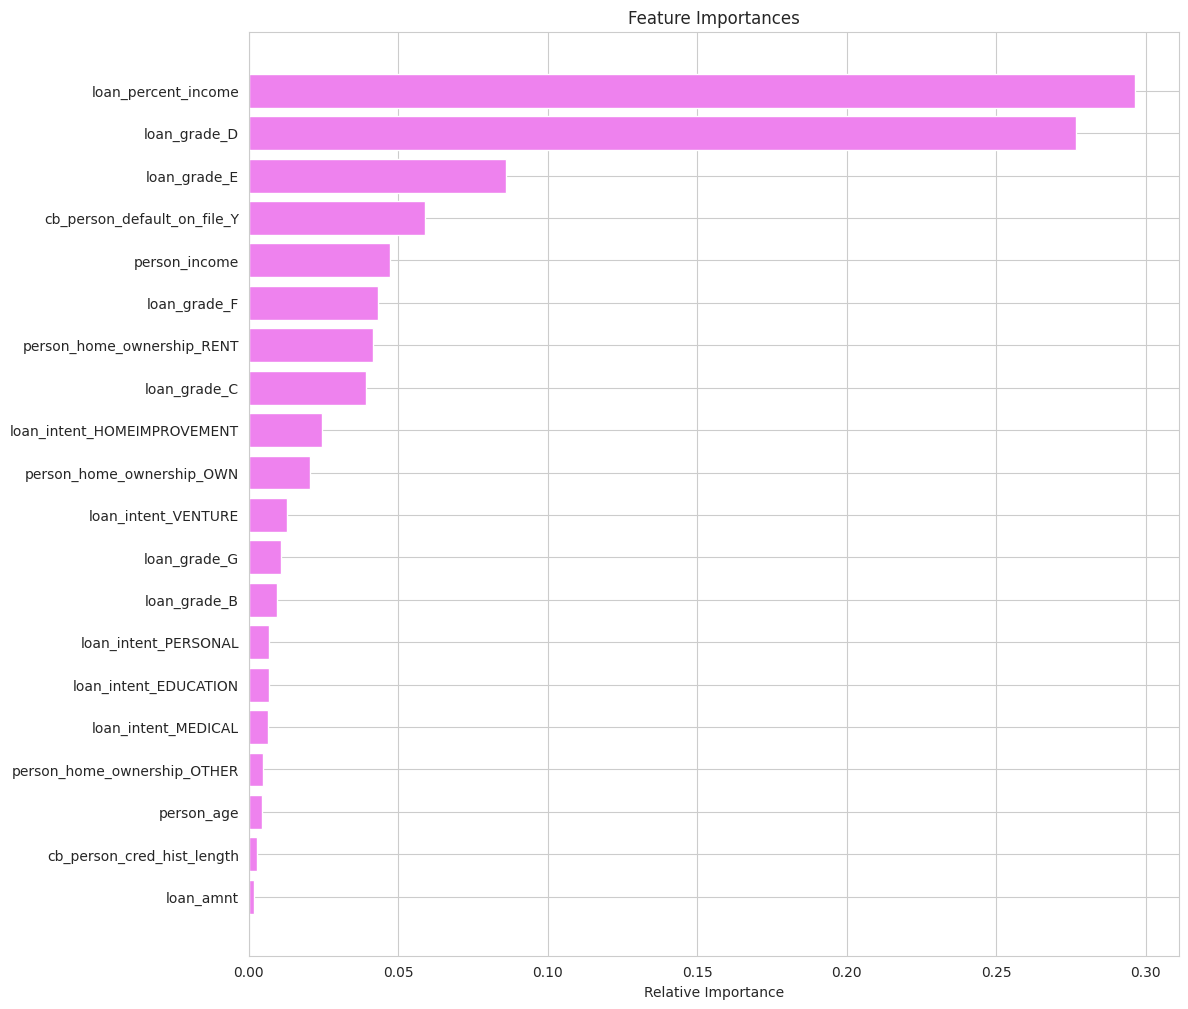

In [74]:
feature_names = X_train.columns
importances =  tuned_xgb.feature_importances_ ## Complete the code to check the feature importance of the best model
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()